# Isolating Variable Stars

The purpose of this notebook is to narrow down the source of variations in a cluster's lightcurve to a specific point of the TPF. From there, we can determine which stars are likely candidates. We will do this by splitting the TPF into a two-by-two grid of sections, finding the light curve of each, taking the section with the light curve most similar to the lightcurve of the whole ensemble, and splitting that section, repeating the process. 

In order to do background correction, we will continue to use the flux of the *entire* TPF, not the section of the TPF we're looking at. I think this should not be an issue, unless some corners of the image are brighter than others. To test this, I added all the section light curves back together and compared it to the ensemble lightcurve. There was good agreement (see *add-back-lightcurves.ipynb*. I think it's important to use the whole sky mask because, in other tests, I saw that generally the more background pixels there are, the better the background correction is. So I elected to keep as many background pixels as possible.

In order to compare lightcurves which have different means, I display the histogram of flux values in each lighcurve. The range of the horizontal axis for each histogram is the highest range of fluxes of all the lightcurves, scaled by the lightcurve's mean. So if there are two lightcurves, one with a min of 1, a max of 3, and a mean of 2, and the second with a min of 19, a max of 21, and a mean of 20, the histogram flux range for the first would be \[1, 3\] to include all the points, and the second would be \[10, 30\] &mdash; the range of the first histogram but scaled by the mean.

In [88]:
%matplotlib inline
import lightkurve as lk
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import math
from scipy import stats

#CLUSTERS = ["NGC 752", "NGC 6231", "NGC 3532"]
CLUSTERS = ["NGC 6231"]#, "IC 2391"]
CLUSTERS = ["NGC 752", "IC 2391", "NGC 6231", "Lambda Orionis", "NGC 3532", "Omega Cen", "47 Tuc"]
COORDS = {"M34":(40.53083, 42.74615), "M7":(268.46325, -34.79283), "NGC 752":(29.421, 37.785), "IC 2391": (130.133, -53.033), 
          "NGC 6231":(253.53546, -41.82667), "Lambda Orionis":(83.784490, 9.934156), "NGC 3532":(166.44923, -58.7705),
          "Collinder 140":("111.113000", "-31.850000"),
          "Omega Cen": (201.69121, -47.47686), "47 Tuc": (6.022329, -72.081444), "NGC 6752": (287.71575, -59.98185)}
LIGHTKURVE_CACHE = "/home/jtdinsmo/.lightkurve-cache/tesscut/"
NUMBER_PCA_COMPONENTS = 10

SCALE_FACTOR = 1.5
LOWER_LIMIT = 10

DIVISIONS = [3, 3]
FFI_SIZE = 180
CUTOFF_PERCENTILE = 3

In [89]:
def countMaxima(data):
    stars = 0
    
    def getValue(x, y):
        if x < 0 or x >= data.shape[0] or y < 0 or y >= data.shape[0]:
            return 0 # Count this pixel as automatically smaller than everything else
        if np.isnan(data[x][y]):
            return 0 # Count this pixel as automatically smaller than everything else.
        if data[x][y] < LOWER_LIMIT:
            return 0 # Count this pixel as automatically smaller than everything else.
        return data[x][y]
        
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            b = data[x][y]
            if np.isnan(b): continue # Don't count nan pixels
            if b < LOWER_LIMIT: continue # Don't count pixels on edge of sector
            up = getValue(x, y-1)
            down = getValue(x, y+1)
            left = getValue(x-1, y)
            right = getValue(x+1, y)
            if b > max(up, down, left, right):
                stars += 1
    return stars

In [90]:
tpfs = [0]*len(CLUSTERS)

class Cluster:
    def __init__(self, name):
        self.name = name
        self.tpf = 0
        
        foundLocal = False
        for file in os.listdir(LIGHTKURVE_CACHE):
            if file.endswith("180x180_astrocut.fits"): # Confirm size
                if COORDS[name][0] == float(file.split("_")[-4]): # Confirm RA
                    if COORDS[name][1] == float(file.split("_")[-3]): # Confirm dec
                        self.tpf = lk.TessTargetPixelFile(LIGHTKURVE_CACHE + file)
                        foundLocal = True
                        break
        if not foundLocal:
            search = lk.search_tesscut(name)
            char = ""
            if len(search) != 1: char = "s"
            print("{0} has {1} result{2}.".format(self.name, len(search), char))
            self.tpf = search[0].download(cutout_size=180)
        
        #self.image = self.tpf[self.tpf.flux.shape[0] // 2].flux.reshape((180, 180))
        self.image = np.mean(self.tpf.flux, axis=0)
        self.upperLimit = None
        
        
    def getLimitMaximaMethod(self):
        numMaxima = countMaxima(self.image)
        notNanMask = ~np.isnan(self.image)
        notEdgeMask = self.image > LOWER_LIMIT
        numPixels = np.count_nonzero(notNanMask & notEdgeMask) # Count the number of pixels that
            # are not nan and are greater than LOWER_LIMIT.
        n = 100 - SCALE_FACTOR * numMaxima / numPixels * 100
        self.upperLimit = np.nanpercentile(self.image, n)# Upper limit of the sky pixel flux range
        print("{0} maxima: {1} / {2} = {3}%. n={4}".format(self.name, numMaxima, numPixels, numMaxima / numPixels*100, n))
        
    
    def getMasks(self):
        self.getLimitMaximaMethod()
        #self.getLimitBinMethod()
        self.skyMask = ((self.image >= LOWER_LIMIT) & # Exclude edge pixels
            (self.image <= self.upperLimit)).reshape(180, 180).astype(bool)
        self.starMask = ((self.image > self.upperLimit)).reshape(180, 180).astype(bool)
        
        
    def generateLightcurves(self):
        rootLC = self.tpf.to_lightcurve(aperture_mask=self.starMask)
        regressor = self.tpf.flux[:, self.skyMask]# The regressor is the inverse of the aperture

        dm = lk.DesignMatrix(regressor, name='regressors').pca(NUMBER_PCA_COMPONENTS).append_constant()
        corrector = lk.RegressionCorrector(rootLC)
        self.correctedRootLC = corrector.correct(dm)
        
        self.correctedLCs = []
        self.qs = []
        for x in range(DIVISIONS[0]):
            lineLC = []
            lineQs = []
            for y in range(DIVISIONS[1]):
                tempStarMask = np.zeros_like(self.starMask)
                tempStarMask[int(FFI_SIZE / DIVISIONS[0] * x) : int(FFI_SIZE / DIVISIONS[0] * (x+1)),
                                  int(FFI_SIZE / DIVISIONS[1] * y) : int(FFI_SIZE / DIVISIONS[1] * (y+1))] = \
                self.starMask[int(FFI_SIZE / DIVISIONS[0] * x) : int(FFI_SIZE / DIVISIONS[0] * (x+1)),
                                  int(FFI_SIZE / DIVISIONS[1] * y) : int(FFI_SIZE / DIVISIONS[1] * (y+1))]
                
                lc = self.tpf.to_lightcurve(aperture_mask=tempStarMask)

                #regressor = self.tpf.flux[:, self.skyMask]# The regressor is the inverse of the aperture

                #dm = lk.DesignMatrix(regressor, name='regressors').pca(NUMBER_PCA_COMPONENTS).append_constant()
                corrector = lk.RegressionCorrector(lc)
                correctedLC = corrector.correct(dm)
                
                lowCutoff = np.nanpercentile(correctedLC.flux, CUTOFF_PERCENTILE)
                highCutoff = np.nanpercentile(correctedLC.flux, 100 - CUTOFF_PERCENTILE)
                q = (lowCutoff < correctedLC.flux) & (correctedLC.flux < highCutoff)
                correctedLC.time = correctedLC.time[q]
                correctedLC.flux = correctedLC.flux[q]
                
                lineQs.append(q)
                lineLC.append(correctedLC)
                
            self.correctedLCs.append(lineLC)
            self.qs.append(lineQs)
            
    def generateChiSq(self):
        self.pVals = []
        
        for x in range(DIVISIONS[0]):
            line = []
            for y in range(DIVISIONS[1]):
                # Set scale so that the means of the light curves are the same
                scale = np.mean(self.correctedRootLC.flux[self.qs[x][y]]) / np.mean(self.correctedLCs[x][y].flux)
                
                p = stats.chisquare(self.correctedLCs[x][y].flux * scale, self.correctedRootLC.flux[self.qs[x][y]], 
                                    ddof=len(self.correctedLCs[x][y].time)-1)
                #p = 1 - stats.chi2.cdf(chisq, len(self.correctedLCs[x][y].time)-1)
                
                print("({0}, {1}): p-value: {2}".format(x, y, p))
                line.append(p)
            self.pVals.append(line)
            
    
    def displayFluxHistograms(self):
        r = max(self.correctedRootLC.flux) - min(self.correctedRootLC.flux)
        maxRange = r / np.nanmean(self.correctedRootLC.flux)
        # Get the maximum range
        for x in range(DIVISIONS[0]):
            for y in range(DIVISIONS[1]):
                r = max(self.correctedLCs[x][y].flux) - min(self.correctedLCs[x][y].flux)
                maxRange = max(maxRange, r / np.nanmean(self.correctedLCs[x][y].flux))
                
        # Draw full image hist
        fig, ax = plt.subplots(ncols=1, figsize=(16,4))
        mean = np.nanmean(self.correctedRootLC.flux)
        minBin = mean - maxRange  * mean / 2
        maxBin = mean + maxRange  * mean / 2
        bins = np.arange(minBin, maxBin, maxRange  * mean / 100)
        ax.hist(self.correctedRootLC.flux, bins=bins)
        ax.set_title("Histogram of fluxes for {0}.".format(self.name));
        ax.set_xlabel("Flux value")
        ax.set_ylabel("Flux counts")
        
        fig, ax = plt.subplots(DIVISIONS[0], DIVISIONS[1], figsize=(16,8))                
        for x in range(DIVISIONS[0]):
            for y in range(DIVISIONS[1]):
                mean = np.nanmean(self.correctedLCs[x][y].flux)
                minBin = mean - maxRange  * mean / 2
                maxBin = mean + maxRange  * mean / 2
                bins = np.arange(minBin, maxBin, maxRange  * mean / 100)
                ax[x, y].hist(self.correctedLCs[x][y].flux, bins=bins);
                
                
    def displayTPFs(self):
        fig, ax = plt.subplots(ncols=1, figsize=(4, 4))
        a = ax.imshow(self.image, vmax=np.nanpercentile(self.image, 95))
        ax.set_title("{0}: (Full image)".format(self.name))
        plt.colorbar(a, ax=ax)
        
        fig, ax = plt.subplots(DIVISIONS[0], DIVISIONS[1], sharex='col', sharey='row', figsize=(10,10))
        for x in range(DIVISIONS[0]):
            for y in range(DIVISIONS[1]):
                image= self.image[int(FFI_SIZE / DIVISIONS[0] * x) : int(FFI_SIZE / DIVISIONS[0] * (x+1)),
                                  int(FFI_SIZE / DIVISIONS[1] * y) : int(FFI_SIZE / DIVISIONS[1] * (y+1))]
                a = ax[x, y].imshow(image, vmax=np.nanpercentile(image, 95))
                #plt.colorbar(a, ax=ax[x, y])
        
    def displayLightcurves(self):
        fig, ax = plt.subplots(ncols=1, figsize=(16,4))
        self.correctedRootLC.scatter(ax=ax, color='k');
        ax.set_title("TESS 2-min lightcurve for {0}, corrected.".format(self.name));
        
        fig, ax = plt.subplots(DIVISIONS[0], DIVISIONS[1], figsize=(16,8))
        for x in range(DIVISIONS[0]):
            for y in range(DIVISIONS[1]):
                self.correctedLCs[x][y].scatter(ax=ax[x, y], color='k');
                ax[x, y].set_xlabel("");
                ax[x, y].set_ylabel("");                

NGC 752 maxima: 1402 / 32400 = 4.327160493827161%. n=93.50925925925925
IC 2391 maxima: 2094 / 32400 = 6.462962962962964%. n=90.30555555555556
NGC 6231 maxima: 2643 / 32400 = 8.157407407407408%. n=87.76388888888889
Lambda Orionis maxima: 1666 / 32400 = 5.1419753086419755%. n=92.28703703703704


/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:150: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

NGC 3532 maxima: 1951 / 32400 = 6.021604938271604%. n=90.9675925925926


/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:141: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

Omega Cen maxima: 2227 / 32400 = 6.873456790123457%. n=89.68981481481481


/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:141: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

47 Tuc maxima: 2271 / 32400 = 7.0092592592592595%. n=89.48611111111111


/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:141: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

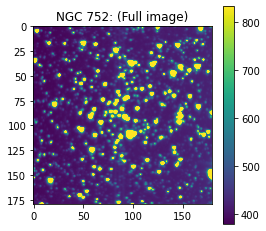

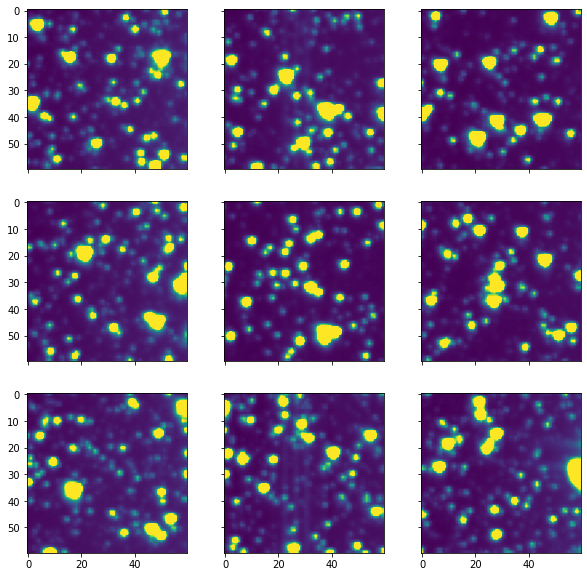

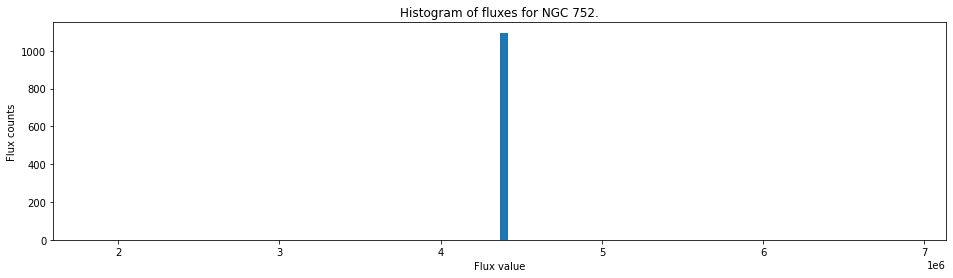

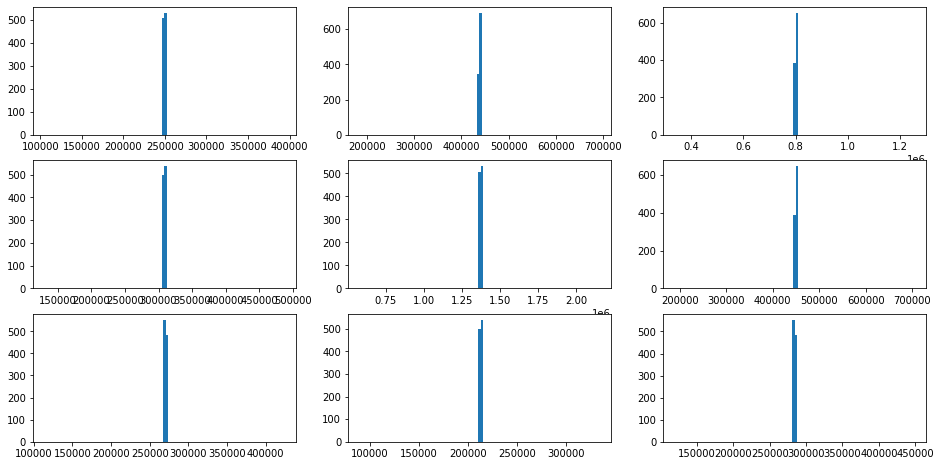

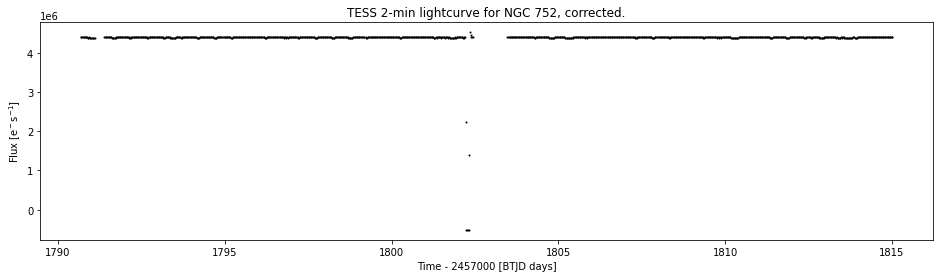

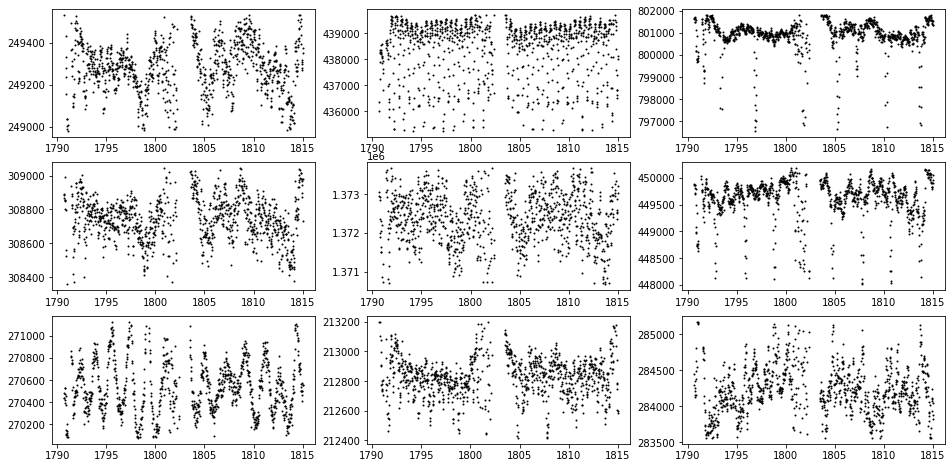

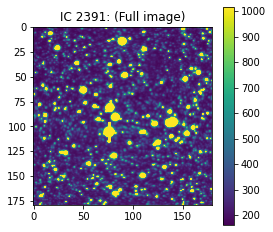

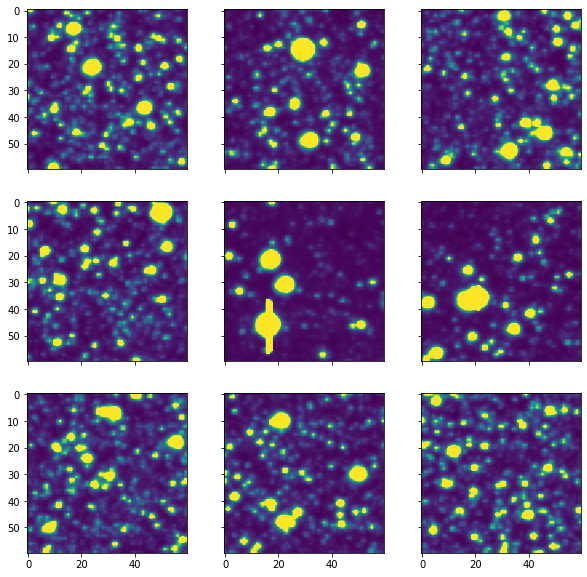

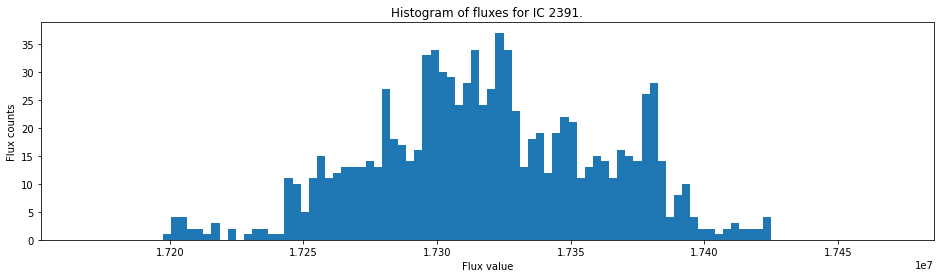

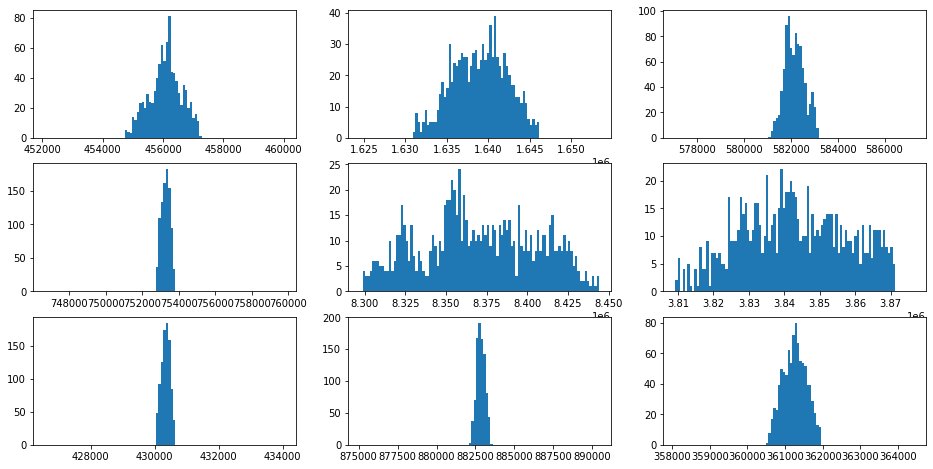

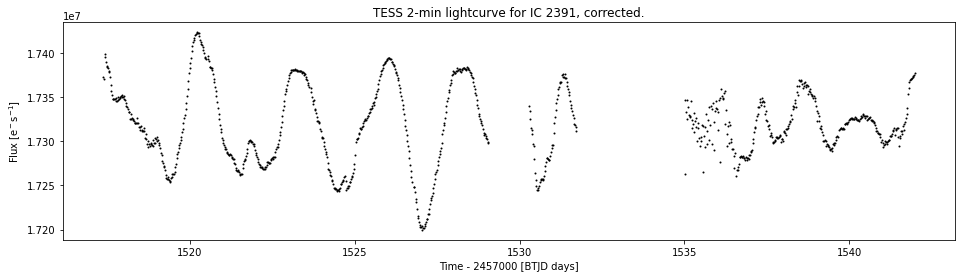

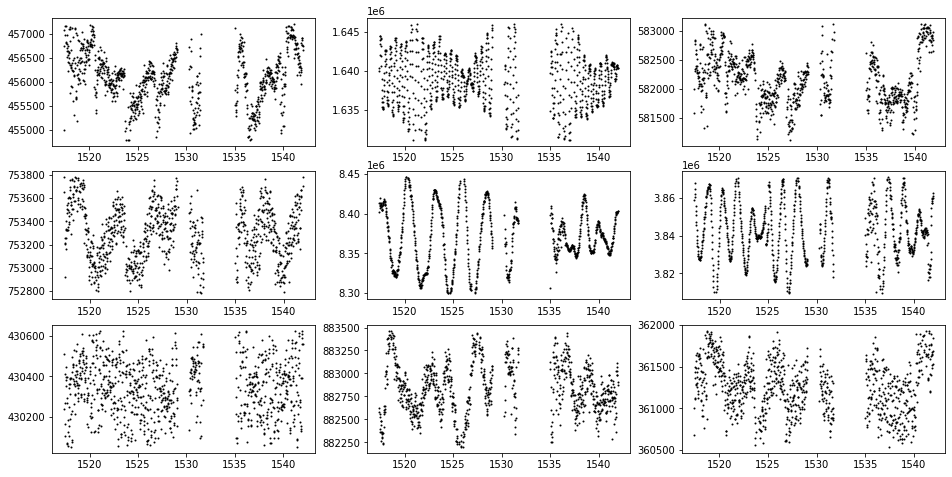

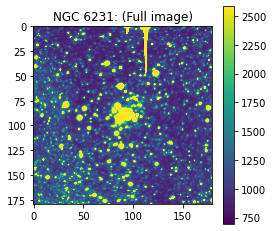

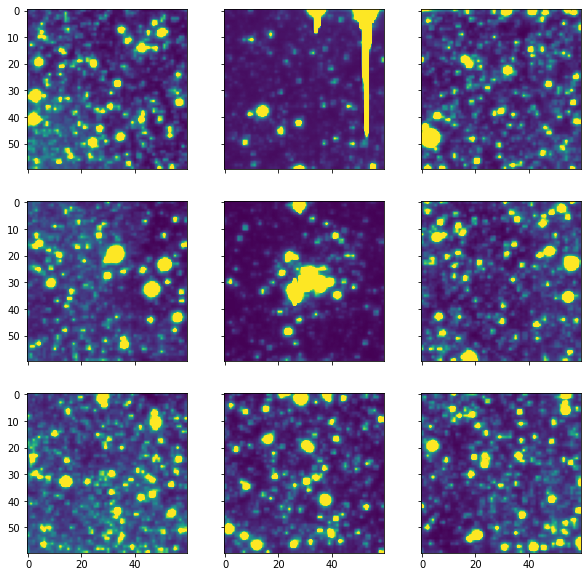

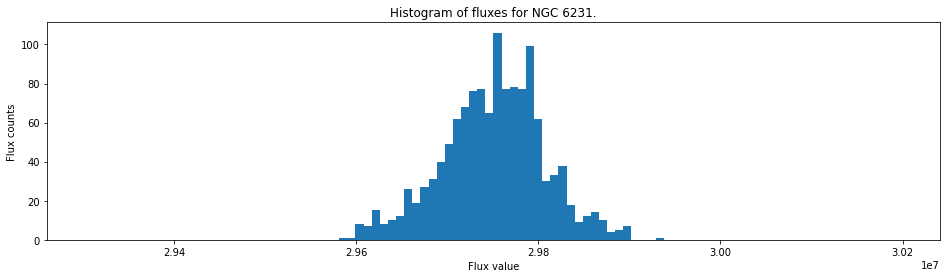

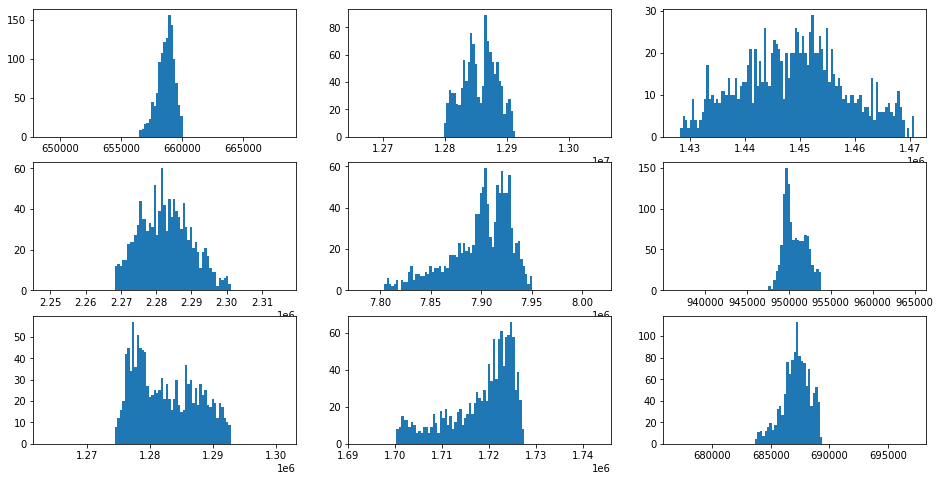

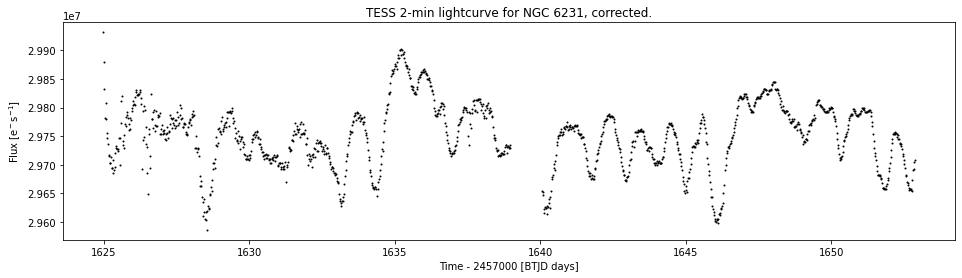

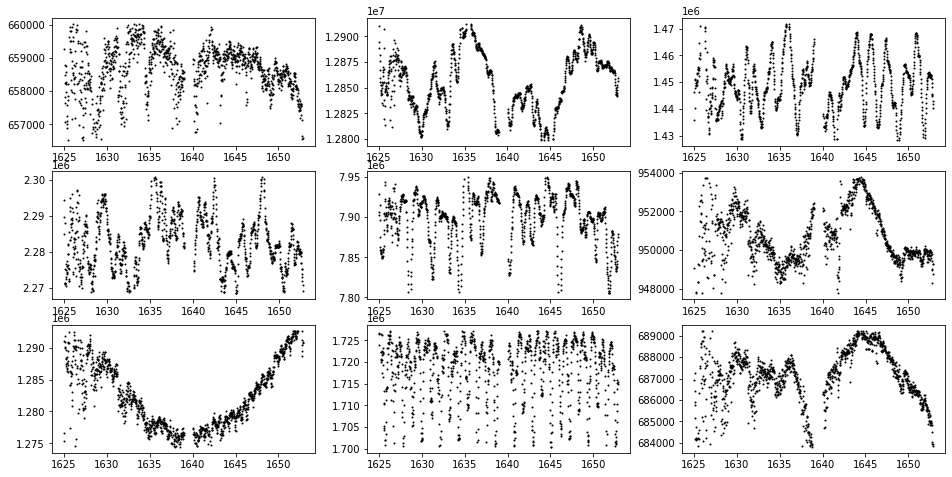

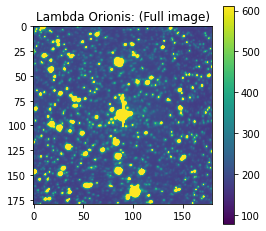

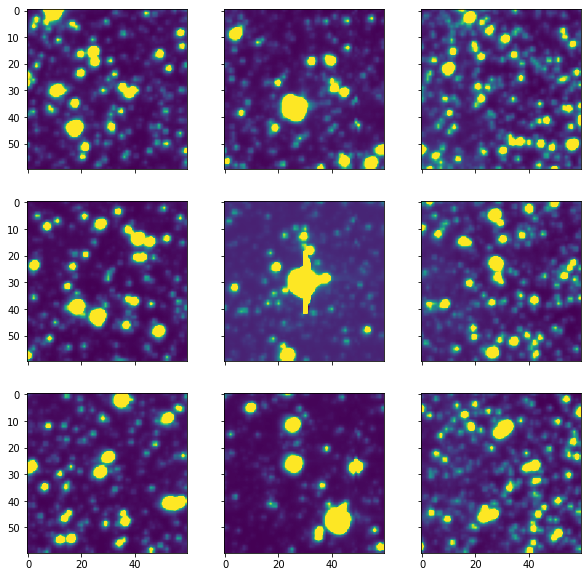

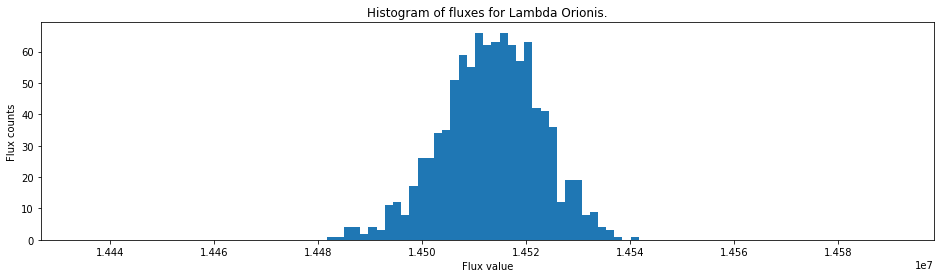

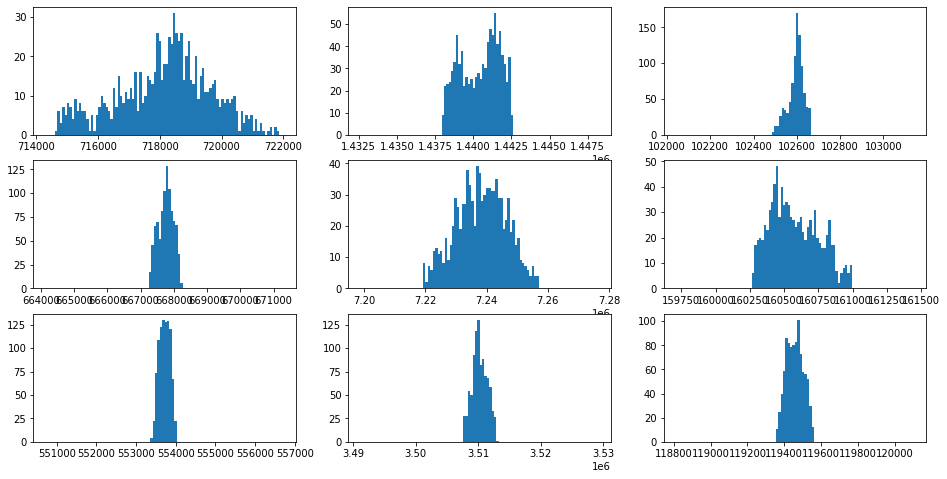

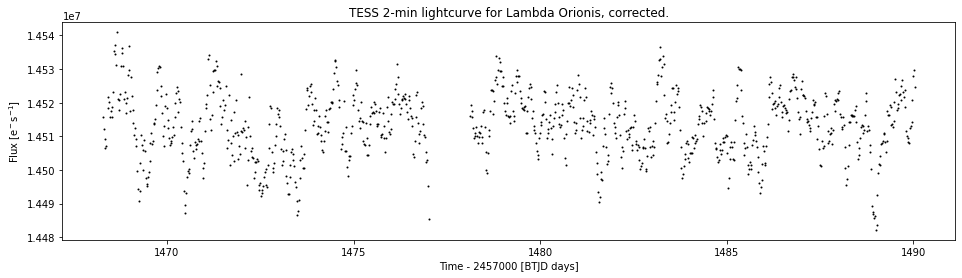

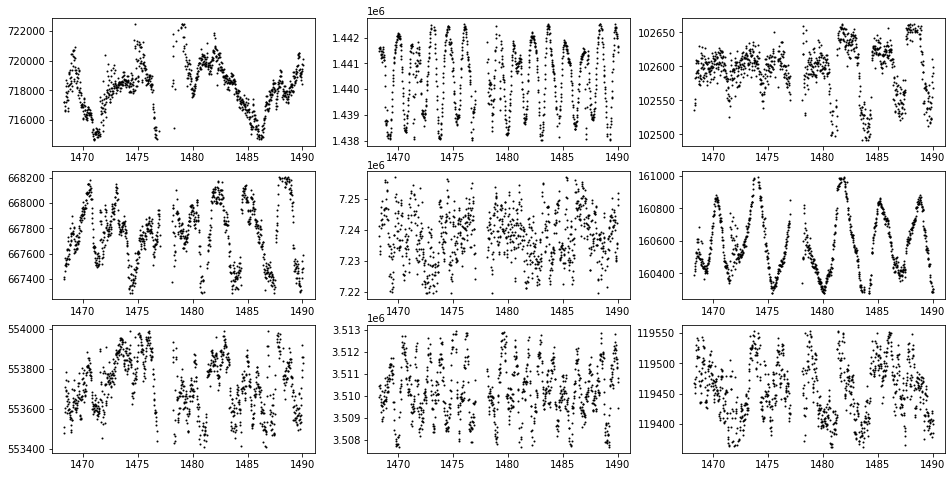

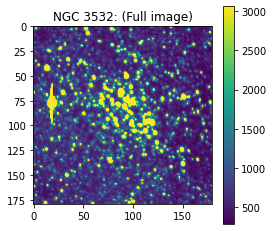

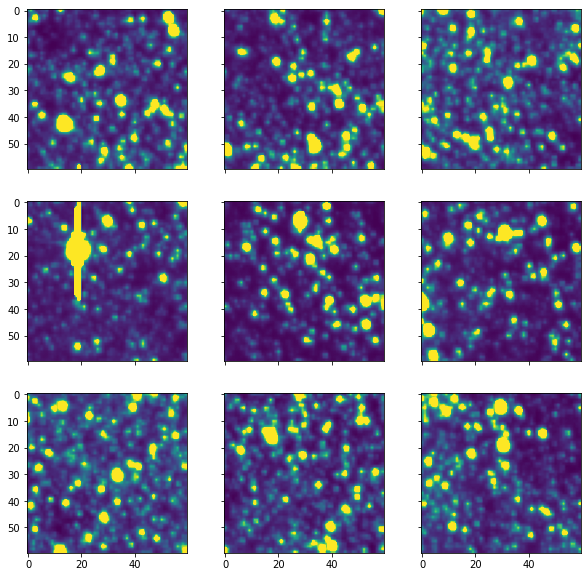

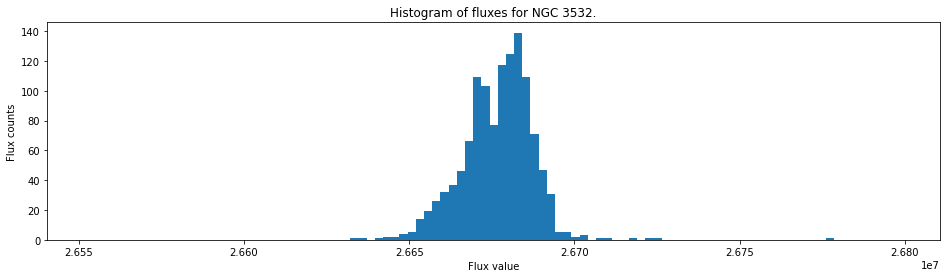

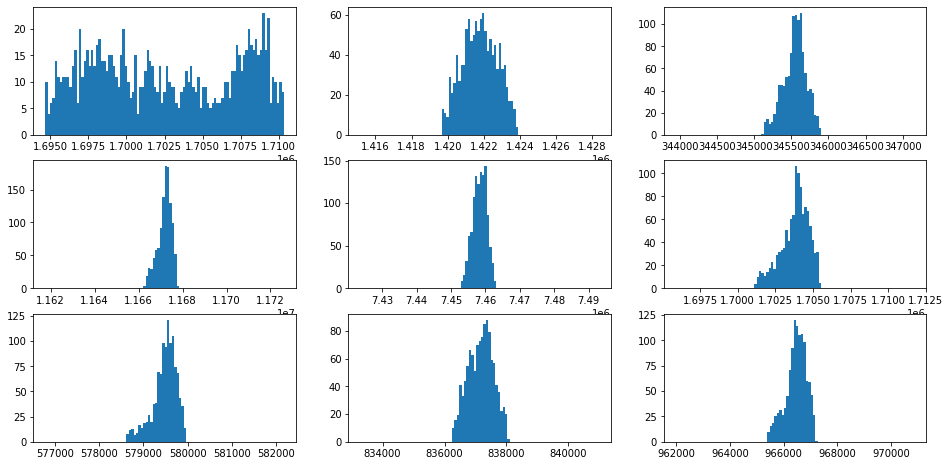

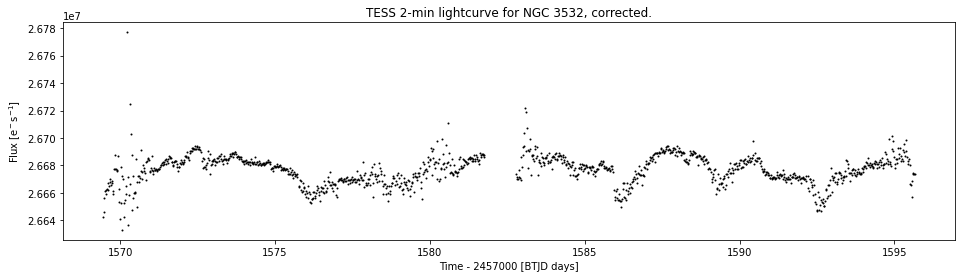

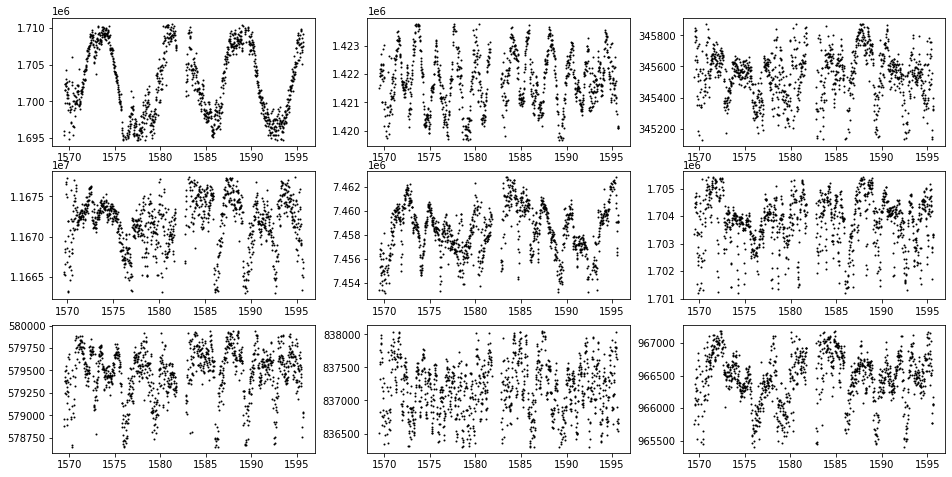

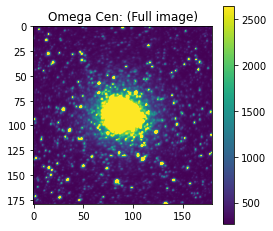

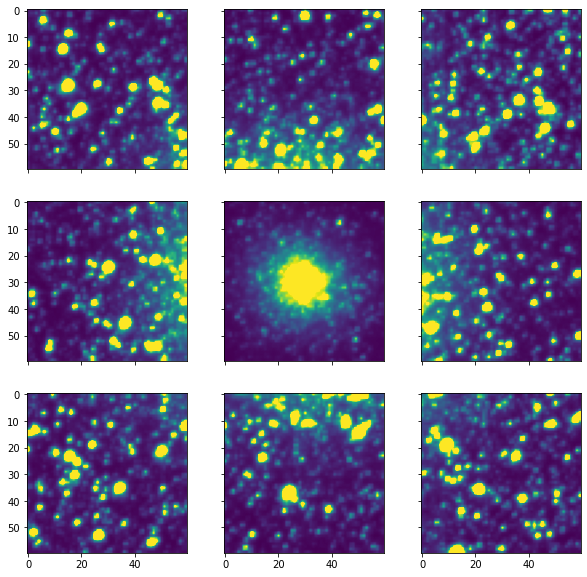

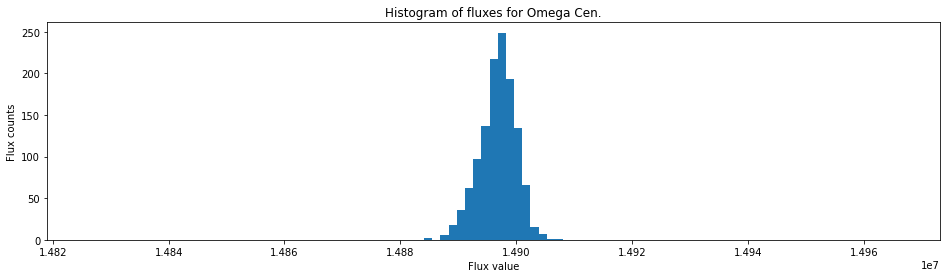

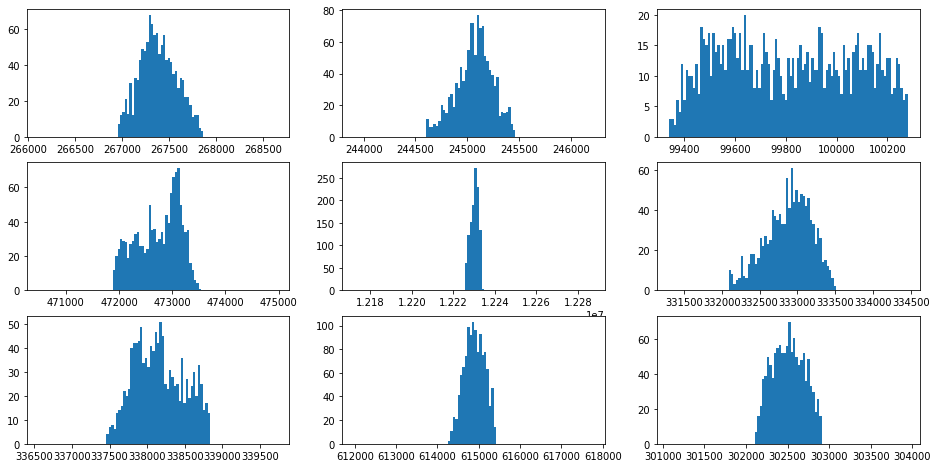

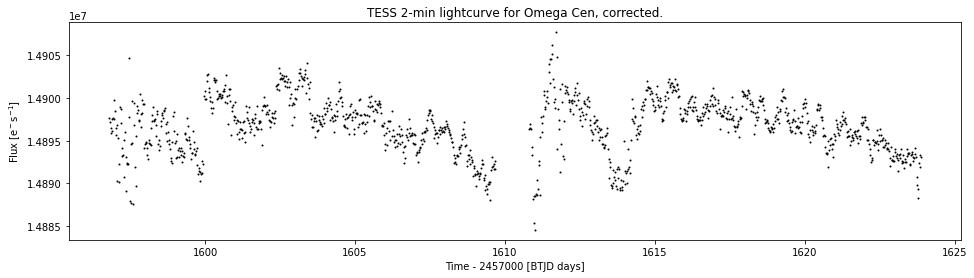

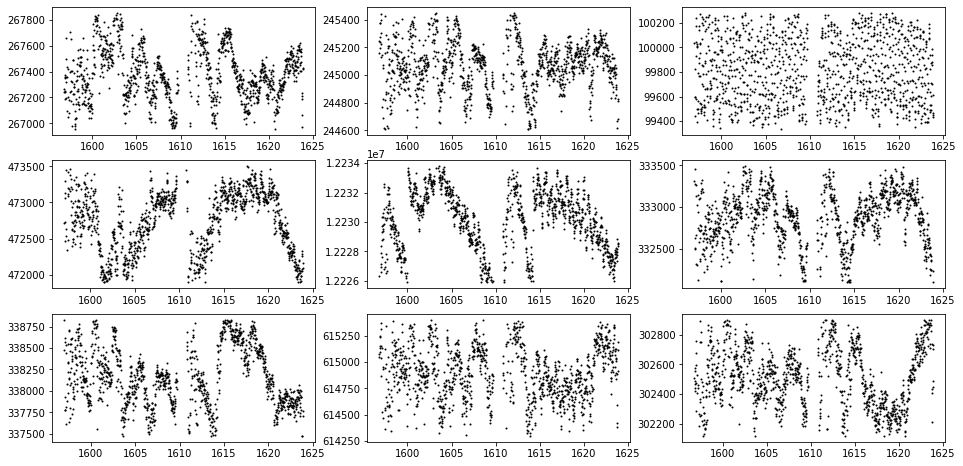

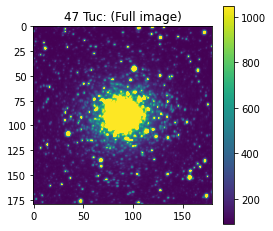

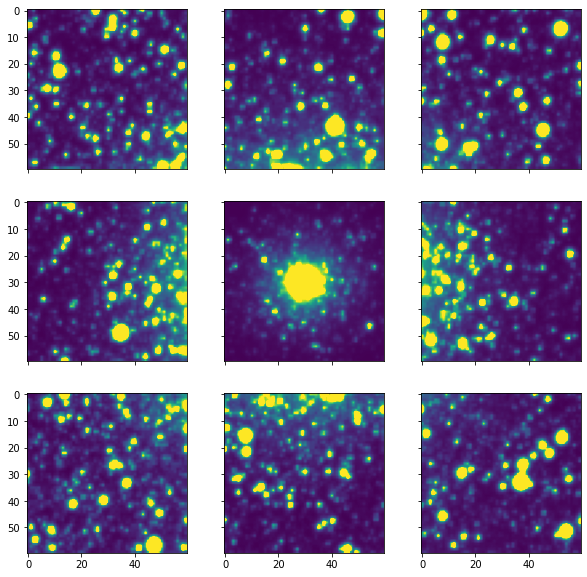

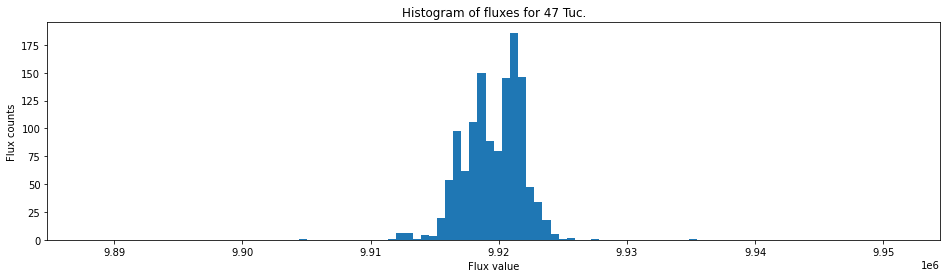

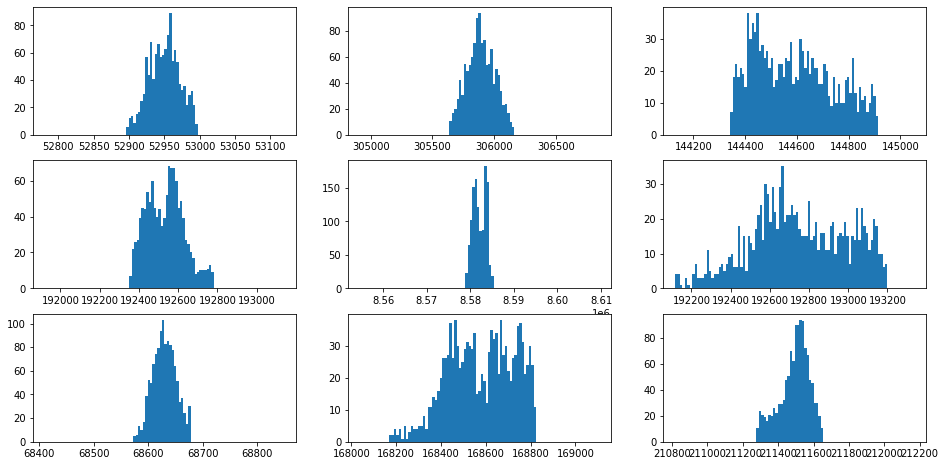

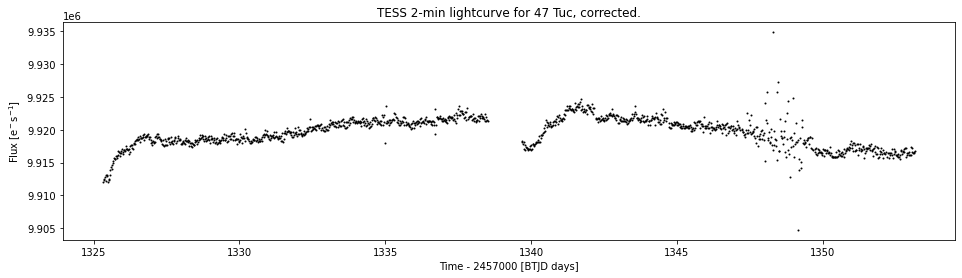

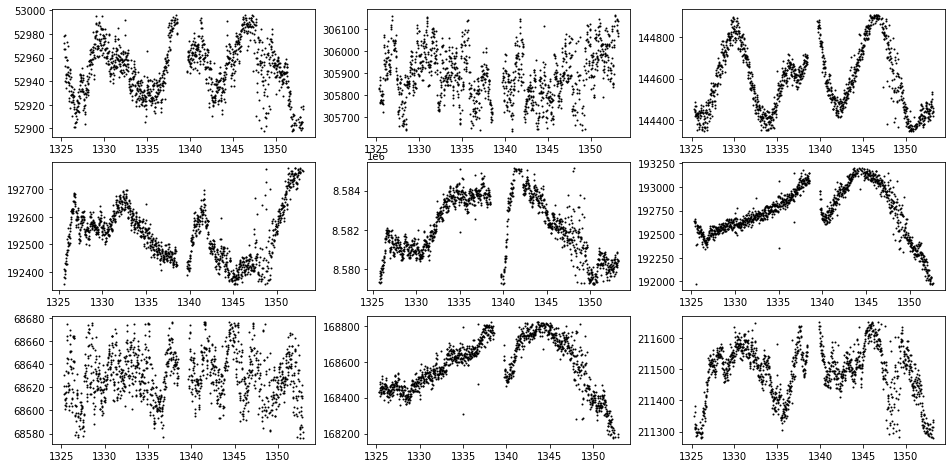

In [91]:
for c in CLUSTERS:
    cl = Cluster(c)
    cl.getMasks()
    cl.generateLightcurves()
    #cl.generateChiSq()
    cl.displayTPFs()
    cl.displayFluxHistograms()
    cl.displayLightcurves()

## Conclusion: 

In this notebook, we saw that different parts of the image vary differently, and in some clusters, one is not obviously dominant.